# Treinamento Multilayer Perceptron

**Python:** 3.12.2

## Imports

In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
import joblib

# diferentes tipos de experimentos
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

import matplotlib.pyplot as plt

import time
import dependencies as dep

In [2]:
SIZE = 800

PATH = '../data/data.csv'
PATH_BALANCED = f'../data/data_balanced_{SIZE}.csv'
MODEL_PATH = '../knn.pkl'

X = 1
O = -1
BLANK = 0

O_WIN   = 0
DRAW    = 1
ONGOING = 2
X_WIN   = 3
class_names = ['O_WIN', 'DRAW', 'ONGOING', 'X_WIN']

## Preparo dos Dados
Devido o péssimo desempenho deste algoritmo até então, vou seguir algumas práticas para dados desbalanceados.

Referências seguidas:

- [Imbalanced Datasets - Google Developers](https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets?hl=pt-br)
- [Best Cross-Validation for Imbalanced Data](https://www.reddit.com/r/datascience/comments/1hba8s2/best_crossvalidation_for_imbalanced_data/)
- [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
- [kNN and unbalanced classes](https://stats.stackexchange.com/questions/341/knn-and-unbalanced-classes)

In [3]:
df = pd.read_csv(PATH_BALANCED)
feature_cols = [str(i) for i in range(9)]
X = df[feature_cols]

y = df['category']
df.sample(10)

,0,1,2,3,4,5,6,7,8,category
1050,-1,1,0,1,1,0,-1,-1,1,2
506,-1,1,1,-1,1,-1,-1,0,1,0
1531,-1,0,-1,1,1,1,0,1,-1,3
1078,1,0,-1,1,0,0,-1,0,0,2
1210,0,-1,-1,1,0,0,0,1,0,2
627,1,0,-1,0,1,-1,0,1,-1,0
2890,-1,-1,1,1,1,-1,-1,1,-1,1
849,0,0,1,1,0,-1,-1,1,0,2
65,-1,0,-1,1,-1,1,0,1,-1,0
2917,-1,1,1,1,-1,-1,-1,1,1,1


In [4]:
X_train, X_temp, y_train, y_temp = tts(X, y, test_size=0.4, random_state=12, stratify=y)
X_val, X_test, y_val, y_test = tts(X_temp, y_temp, test_size=0.5, random_state=12, stratify=y_temp)

## Treinamento

In [5]:
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = RepeatedStratifiedKFold(n_splits=22, n_repeats=11, random_state=42)

param_grid = {
    'n_neighbors' : [1, 2, 3, 4, 5, 6, 7],
    'weights' : ['distance', 'uniform'],
    'p' : [1, 2]
}
knn = KNeighborsClassifier(metric='minkowski')
grid = GridSearchCV(knn, param_grid, cv=cv, scoring='f1_macro', return_train_score=True, n_jobs=-1)

train_start = time.time()
model = grid.fit(X_train.to_numpy(), y_train.to_numpy())
train_end = time.time()
print(f"Tempo de Indução: {train_end-train_start} segundos")

Tempo de Indução: 70.92699098587036 segundos


Melhores Hiperparâmetros={'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
Melhor F1=0.8918911005487554


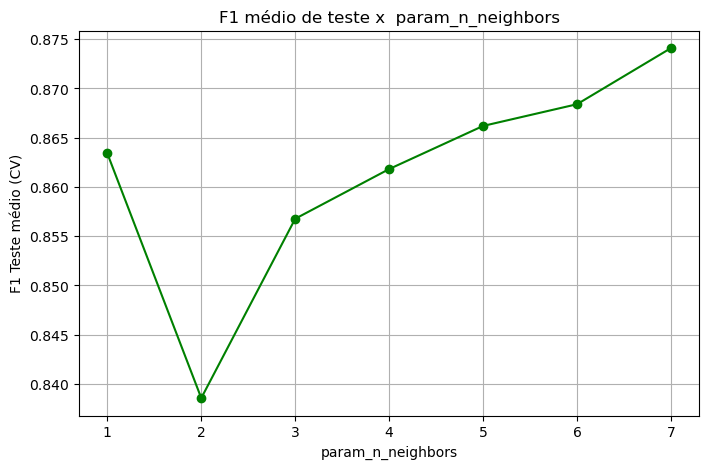

    param_n_neighbors param_weights  param_p  mean_test_score
26                  7      distance        2         0.891891
22                  6      distance        2         0.886973
24                  7      distance        1         0.882918
18                  5      distance        2         0.882844
20                  6      distance        1         0.881321
14                  4      distance        2         0.878415
16                  5      distance        1         0.877826
12                  4      distance        1         0.873849
10                  3      distance        2         0.871050
8                   3      distance        1         0.867914
27                  7       uniform        2         0.866305
2                   1      distance        2         0.864268
3                   1       uniform        2         0.864268
0                   1      distance        1         0.862509
1                   1       uniform        1         0.862509


In [6]:
print('Melhores Hiperparâmetros='+str(model.best_params_))
print('Melhor F1=' + str(model.best_score_))
results = pd.DataFrame(model.cv_results_)

# Agrupa por max_depth e calcula média do mean_test_score
agg_dt = (results
        .groupby('param_n_neighbors')['mean_test_score']
        .mean()
        .reset_index())

plt.figure(figsize=(8, 5))
plt.plot(agg_dt['param_n_neighbors'], agg_dt['mean_test_score'], marker='o', color='green')
plt.xlabel('param_n_neighbors')
plt.ylabel('F1 Teste médio (CV)')
plt.title('F1 médio de teste x  param_n_neighbors')
plt.grid(True)
plt.show()

print(results[['param_n_neighbors', 'param_weights', 'param_p', 'mean_test_score']]
    .sort_values(by='mean_test_score', ascending=False)
  .head(15))

## Teste

[INFO] Tempo de inferência: 0.0150 s

========== CLASSIFICATION REPORT ==========
              precision    recall  f1-score   support

       O_WIN     0.9191    0.9938    0.9550       160
        DRAW     0.9143    1.0000    0.9552       160
     ONGOING     0.9565    0.6875    0.8000       160
       X_WIN     0.8814    0.9750    0.9258       160

    accuracy                         0.9141       640
   macro avg     0.9178    0.9141    0.9090       640
weighted avg     0.9178    0.9141    0.9090       640


 ========== CONFUSION MATRIX ==========


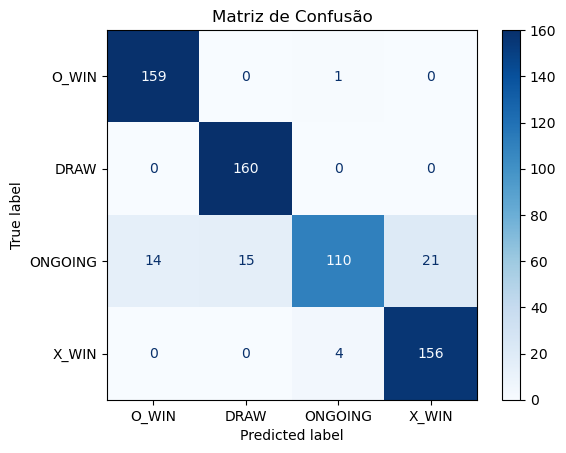


 ========== ROC CURVES (OVR) ==========


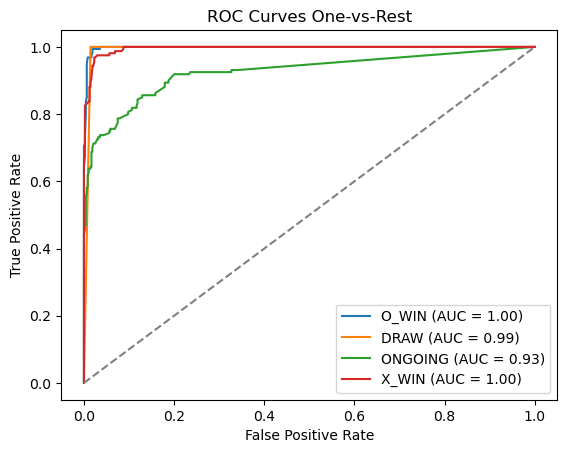


 ========== CALIBRATION CURVES ==========


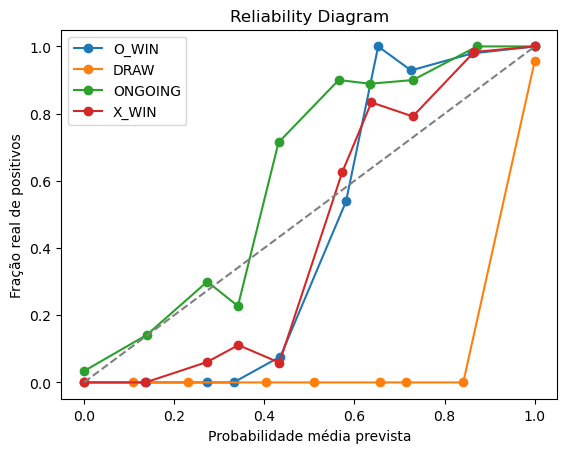

In [7]:
dep.test_model(model, X_val, y_val, class_names)

### Análise de Resultados - Testes:
#### Matriz de Confusão
- `O_WIN`, `X_WIN`, `DRAW` com valores muito aceitáveis
- `ONGOING`
  - com recall baixo, sendo classificada errôneamente 37% das vezes.
  - com precision alto, com 92% de verdadeiros positivos.
    - O modelo subnotifica classes ONGOING.
#### Curva ROC
- AUC `O_WIN`, `X_WIN`, `DRAW` com valores acima de 99%, excelente separabilidade
- AUC `ONGOING` com valor de 89%, indica dificuldade em ranquear corretamente ONGOING

### Calibração
- `O_WIN` e `X_WIN`: relativamente bem calibradas (curva próxima da diagonal).
- `ONGOING`: Nos bins médios (0.3–0.6), o modelo superestima a probabilidade real (pontos acima da linha).
- `DRAW`: quase todos os pontos zerados até o último bin, o modelo raramente atribui probabilidade média consistente a empates, resultando em calibração ruim para esses casos.

In [8]:
joblib.dump(model, MODEL_PATH)
print(f'KNN salvo em {MODEL_PATH}')

KNN salvo em ../knn.pkl
